<a href="https://colab.research.google.com/github/Henning-Kubatzsch/Tutorials/blob/main/Makemore/02_Makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Makemore-02



**Multilayer Perceptron (MLP) Language Model – Summary**

A multilayer perceptron (MLP) is used to build a character-level language model, following the classic approach from Bengio et al. (2003). This implementation also introduces key machine learning concepts such as model training, hyperparameter tuning, evaluation metrics, and dataset splitting.

**Key Steps:**

* Walkthrough of the original MLP language model paper
* Rebuild the training dataset with input-output character sequences
* Implement an embedding lookup table to map tokens to vectors
* Construct the hidden layer using `torch.Tensor` (views, storage)
* Add an output layer and compute negative log likelihood loss
* Switch to `F.cross_entropy` for numerical stability and convenience
* Build the training loop, starting with overfitting a single batch
* Train on the full dataset using minibatches
* Tune learning rate and explore its effect on convergence
* Split data into train/validation/test sets to evaluate generalization
* Experiment with larger hidden and embedding dimensions
* Visualize learned character embeddings
* Sample text from the trained model

This model introduces the full training pipeline and prepares for scaling to deeper and more powerful architectures.


## Picture

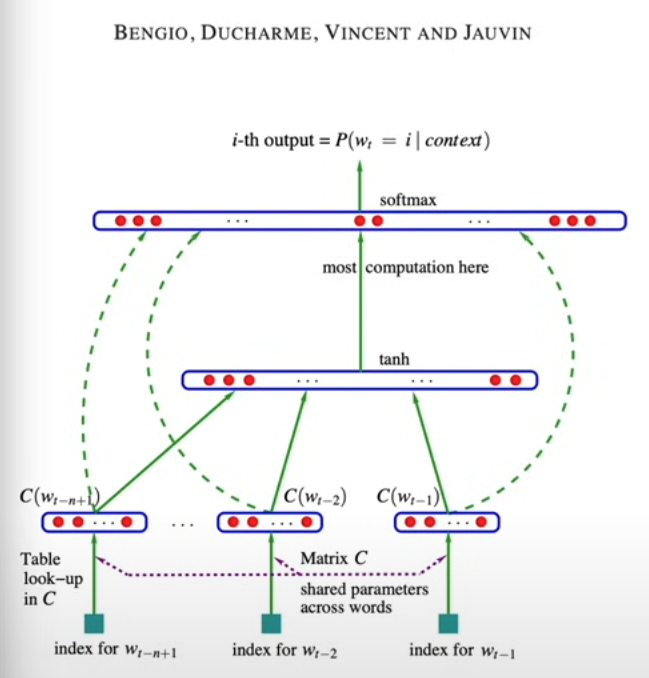

# Initializing dataset and utiliy functions

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all words
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt -O names.txt
words = open('names.txt').read().splitlines()

--2025-04-11 10:10:31--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.05s   

2025-04-11 10:10:32 (4.73 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Compile dataset for the network

## Dataset

In [ ]:
# built the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X,Y = [],[]
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

In [ ]:
#X

## Lookup Table

In [ ]:
C = torch.randn((27, 2))
# print(C[5])
# C.dtype

In [ ]:
# w = F.one_hot(torch.tensor(5), num_classes=27).float()
# w @ C

In [ ]:
# C[[5,6,7]]

In [ ]:
# C[torch.tensor([5,6,7,7,7])]

In [ ]:
# C[X]

In [ ]:
C[X].shape

In [ ]:
X[13, 2]

In [ ]:
C[X][13,2]

In [ ]:
C[1]

In [ ]:
# our embedding
emb = C[X]
emb.shape

# Construct the first hidden Layer

## Initialize first Weights and Biases

In [ ]:
# emb.shape: torch.Size([32, 3, 2])
# input to first hidden layer will be 3*2 as we have 3 two dimensional embeddings
# so the number of inputs 3*2 = 6
# number of neurons we gonna choose: 100

# Weigths W1 for 6 inputs and 100 neurons
W1 = torch.randn((6, 100))

# Biases b1
b1 = torch.randn(100)

## Concatenate Inputs

In [ ]:
# This does not work:
# emb @ W1 + b1

In [ ]:
# we are going to concatenate
# : -> all the examples; 0 -> first of thress tuples; : -> all components of the tuple
emb[:, 0, :].shape

In [ ]:
# second value: dimension over which we concatenate, in this case 1
# using cat is very unefficient compared to torch.view() as it creates a whole new tensor with a whole new storage
# so new memory is created as there is no way to concatenate tensors by just manipulating the view attributes

torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

### way #1
...if we later want to use different input sizes we need to change the code an use torch.unbind to remove tensor dimensions

In [ ]:
emb.shape

In [ ]:
# gives us the same result as [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]
torch.unbind(emb, 1)

# cat from concat
torch.cat(torch.unbind(emb, 1), 1).shape


### way #2
...better and mor efficient
- torch.view() is an extremly efficient operation

In [ ]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
a.shape

...very quickly we can represent this as different sized n-dimensional tensors
view:
- gives us a logical construct of representing+ the physical memory

In [ ]:
a.view(2,9)

In [ ]:
a.view(9,2)

In [ ]:
a.view(3,3,2)

...this works as every tensor has an underlying storage
- .storage() also sores datatype of entries
- .untyped_storage() just stores the raw values (modern way)

In [ ]:
y = torch.randn(3,2,4)

In [ ]:
y.shape

torch.Size([3, 2, 4])

In [ ]:
y.stride()

(8, 4, 1)

In [ ]:
y.view(6,4)

tensor([[ 0.2207,  1.3097, -0.4148,  2.0529],
        [-1.1912,  1.0515,  0.6238, -1.0919],
        [-1.0239, -0.3078, -0.3278,  0.8100],
        [-0.2995, -0.8522, -2.2508,  0.5909],
        [ 2.2846, -2.4104,  1.0904, -1.2157],
        [-1.4449,  0.6649,  1.0714,  0.1586]])

In [ ]:
# storage is beeing deprecated -> use untyped_storage instead

#a.storage().dtype
#a.untyped_storage()

In [ ]:
emb.shape

In [ ]:
emb.view(32, 6) == torch.cat(torch.unbind(emb,1), 1)

### How we go on

In [ ]:
# h = emb.view(32, 6) @ W1 + b1
h = emb.view(emb.shape[0], 6) @ W1 + b1
h = emb.view(-1, 6) @ W1 + b1

In [ ]:
h.shape

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

...now we get numbers between -1 and 1 because of tanh()

In [ ]:
h

In [ ]:
h.shape

### ...about + b1

In [ ]:
h.shape

In [ ]:
(emb.view(-1, 6) @ W1).shape

In [ ]:
b1.shape

In [ ]:
# about broadcasting

# 32, 100
#   , 100

# --> broadcating from the rigth inserts the dimension 1

# 32, 100
#  1, 100

# --> for all the rows of the 32 we will have an element wise addition
# means: the same bias vector will be added to all the rows of the matrix

### The final Layer

# Get normalized probabilities

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims = True)

In [ ]:
prob.shape

In [ ]:
prob[0].sum()

# Using Y for the next Layer

In [ ]:
Y

In [ ]:
loss = - prob[torch.arange(32), Y].log().mean()
loss

# Everything in NICE - make it more respectable ;)

In [ ]:
# initializing the NN
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)

W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [ ]:
# forepass
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)

# classification
counts = logits.exp()
probs = counts / counts.sum(1, keepdim = True)
loss = - probs[torch.arange(32), Y].log().mean()

loss

In [ ]:
# we can also use torch.nn.functional.cross_entropy for classification to calculate much more efficiently
loss = F.cross_entropy(logits, Y)
loss

## Why We Use `CrossEntropyLoss` Instead of Manual Classification

Using PyTorch’s built-in `CrossEntropyLoss` is preferred over a manual classification setup for several important reasons:

1. **Efficiency:** PyTorch avoids building all intermediate tensors (`counts`, `logits.exp()`, `probabilities`, `counts.sum()`, etc.), resulting in faster and more memory-efficient execution.
2. **Optimized Backward Pass:** The backward computation is fused and mathematically simpler, allowing for more efficient gradient calculations.
3. **Numerical Stability:** `CrossEntropyLoss` is implemented in a way that avoids common numerical issues (e.g., with small or very large values), leading to more stable training.


In [ ]:
# to 3

# this is ok:
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
probs

In [ ]:
# this got more extreme values:
# now we run into trouble and get nan
logits = torch.tensor([-100 , -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

In [ ]:
# thats because the counts got an inf -> thats because we run out on dinamic range
counts

In [ ]:
# back to our nice dataset we see that any offset to logits does not change our input
# this is ok:
logits = torch.tensor([-2, -3, 0, 5]) + 4
counts = logits.exp()
probs = counts / counts.sum()
probs

In [ ]:
# what pytorch is doing internally when having a high number: substract this from all other like the (-100)
# this is ok:
logits = torch.tensor([-2, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs

# Now we do the training

In [ ]:
X.shape, Y.shape # dataset

In [ ]:
# initializing the NN
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)

W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for _ in range(1000):
  # forward pass
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

...as we have only a few samples but huge amount of parameters we can get a really low loss, but also we are running into overfitting :(

But we are not able to achieve zero

In [ ]:
# get the max of the first dimension
# pytorch gives us the values and also the indecies
logits.max(1)

In [ ]:
# to indicies now should be very close to the labels:
Y

...for example for the first example the predicted index is 19 but the label is 5

Why we can't get loss to zero:
- examples of training samples:
  - ... ----> e
  - ... ----> o
  - ... ----> a

# Training with the whole dataset

In [ ]:
# built the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X,Y = [],[]
for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

In [ ]:
# initializing the NN
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)

W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
for _ in range(10):
  # forward pass
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

# Don't train on the whole data but on batches

Important to know:
- when working with mini batches, the quality of our gradients gets much lower
- so the directions of those gradients are not as reliable but it is good enough as it is usefull
- as a conlusion: it is much better to have an aproximate gradient of a small batch and just make more steps then to evaluate the exaxt gradient and take fewer steps

## How to iterate on batches

In [ ]:
# generate numbers between 0 and 5 and make 32 of them
torch.randint(0, 5, (32,))

In [ ]:
# What we want is selection random datapoints from X
# our minibatch size in this case is 32
torch.randint(0, X.shape[0], (32, ))

## Do it with batches

In [ ]:
# built the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X,Y = [],[]
for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

In [ ]:
# initializing the NN
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)

W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
# here we calc loos with the small batches

for _ in range(1000 ):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32, ))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

In [ ]:
# now we evaluate the loss over the whole dataset
# forward pass
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss.item()


# Find a good learning rate

In [ ]:
# built the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X,Y = [],[]
for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
# initializing the NN
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)

W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
# here we define spectrum for learning rate
# definition: from, to, steps

# this would be linear -> makes no sence
# torch.linspace(0.001, 1, 1000)

# learning rates exponent
lre = torch.linspace(-3, 0, 1000)
# learning rates steps
lrs = 10**lre
#lrs

In [ ]:
# here we calc loos with the small batches

# learning rate index
lri = []

# loss index
lossi = []

for i in range(1000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32, ))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = 0.1
  lr = lrs[i]
  #print(lr)
  for p in parameters:
    # -00.01: a good steady slow learning rate
    # -01.00: a good very fast learning rate
    # -10.00. not optimizing
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  #lri.append(lr)
  # lri.append(i)
  lossi.append(loss.item())

print(loss.item())

In [ ]:
# on the x-axis now we have the exponent of the learning rate
plt.plot(lri, lossi)

What we see:
- influence of the learning rate to the Loss
- the sweetspot seems to be somewhere at -1

Conclusion:
- we can set our learning rate to 10^-1 -> 0.1

Next step:
- set high iteration number like 10 000 and let it run and optimize

In [ ]:
for i in range(10000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32, ))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

Now let's decrease/ decay learning rate


In [ ]:
for i in range(10000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32, ))

  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

In [ ]:
# now we evaluate the loss over the whole dataset
# forward pass
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss.item()

# Splitting up the dataset

Some points that may need to made:
- the bigger a model gets/ the more parameter it has the higher the probability of overfitting
- that means that the loss on the data your training at becomes very low ...as low as zero
- but if you now try to sample you will only get samples like exactly from the trainings set/ you get no new data
- if you would now input withheld names or other words the loss could be very high
  - so basically: it is not a good model

How to avoid that?
- splitup your datat into 3 splits
  - (80%) training split
    - for training
  - (10%) dev/ validation split
    - develop/ train the hyperparameters of the model (size of hidden layer, size of ebedding, strength of regularization, ... )
  - (10%) test split
    - test the performance of the model at the end
    - we only evaluate the loss on the test plate very sparingly and very few times
    - you are only allowed to test the loss at the test split very few times, otherwise you risk overfitting as well

In [ ]:
# built dataset

def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

#print(len(words[:n1]))
#print(len(words[n1:n2]))
#print(len(words[n2:]))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
# initializing the NN
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# embedding matrix: translates discreate input to continuous vectors
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)

W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

...no using Xtr, Ytr for training

In [ ]:
# high amout of iterations and hughe step sizes
for i in range(30000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

In [ ]:
# fewer iterations and small step sizes
for i in range(10000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

...now using Xdev, Ydev for testing

In [ ]:
# now we evaluate the loss over the whole dataset
# forward pass
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

...and using Xte, Yte for testing

In [ ]:
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss.item()

As the Loss for Training and Evaluation datasets are roughly equal we are underfitting.
- this may result from a to small NN, that can not remember whole datasets
- bigger networks can

# Scaling up the neural network


## First: We try our best with adjusting the learning rate

In [ ]:
# built dataset

def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

#print(len(words[:n1]))
#print(len(words[n1:n2]))
#print(len(words[n2:]))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

...pump ist up
- W1: (6,100) -> (6, 300)
- b1: 100     -> 300
- W2: (100,27)-> (300, 27)

In [ ]:
# initializing the NN
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)

W1 = torch.randn((6, 300), generator = g)
b1 = torch.randn(300, generator = g)

W2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
sum(p.nelement() for p in parameters)

In [ ]:
lri = []
lossi = []
stepi = []

for i in range(30000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.05
  for p in parameters:
    p.data += -lr * p.grad

  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

In [ ]:
plt.plot(stepi, lossi)

What we see:
- as we are using a very small batch size, this could lead to too much noise
- we are still not optimizing the network really well
- how we choose the learning rate:
  - first iterations: 0.1
  - after that decrease to: 0.05
  - at a leater stage we also decrease to: 0.01
...but we still see no significant impovement of the neural network


In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

Waht is the bottelneck of our neural network?
- maybe it is the first layer/ the embedding (they are only 2-dimensional)
  - we are cramming way too many character into two dimensions
  - the neural network is not really able to use this space effectively

## Visualize the Embeddings
Before we start to size up the Neural Network we want to visualize the embeddings:

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

What we see:
- the network has learned to seperate the character and cluster them a little bit
- for example the vowels (a, e, i, o, u) are clustered very closely together
  - means: the neural network treats them very similar
  - means: the embedding for all those characters is very similar/ kind of interchangeable
- very far away: q and g
  - they have a very special embedding vektor

# Increase the Embedding Vectors/ Dimensions

In [ ]:
# built dataset

def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

#print(len(words[:n1]))
#print(len(words[n1:n2]))
#print(len(words[n2:]))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

...now we are going from 2-dimensionel to 10-dimensionel embeddings

In [ ]:
# initializing the NN
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)

W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)

W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
sum(p.nelement() for p in parameters)

In [ ]:
lri = []
lossi = []
stepi = []

Learning Rate:
- we will also again start with 0.1
- then decrease to 0.01

In [ ]:
for i in range(50000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

...we now use loss.log10(). this squashes te outputs a little bit.
- it just looks kind of nicer,

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

What we see:
- loss of our training-set and our dev-set are starting to sligthly slowly depart
- this could mean:
  - the number of parameters is large enough that we slowly overfit


What you would do in production:
- do a lot different experiments
- evaluate which hyperparameter give you the best dev performance
- once you find all the hyperparameters that make dev performance good:
  - you take that model and evaluate the test set performance a single time
    - that the number you report in your paper/ or where ever you want to talk about you model


# How to go on from here
- continue tuning the optimization
- continue playing with the sizes of the neural net
  - change size of hidden layer (tanh)
- change dimensionality of th eebedding/ look-up table
- increase the number of words or characters that we are taking as an input
  - insted of taking three characters as an input -> take more characters as an input
- change details of the optimization
  - how long do i run the model
  - what is the learning rate
  - how does learning rate change over time/ how does it decay
  - change batchsize and  maybe achieve a much better convergence speed (how many minutes to train the model and get results in terms of really good loss)

In [ ]:
# built dataset

def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

#print(len(words[:n1]))
#print(len(words[n1:n2]))
#print(len(words[n2:]))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
# initializing the NN
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)

W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)

W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
sum(p.nelement() for p in parameters)

In [ ]:
lri = []
lossi = []
stepi = []

What we do now:
- high number of iterations
- decrease stepsize at 100 000 iterations


In [ ]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32, ))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i > 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
block_size

# How to sample form the model

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # 1: represents the size of our training set, as we are working with an single element that we are generating our dimension is 1
    emb = C[torch.tensor([context])] # (1, block_sizw, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    # softmax: exmponentiates the logits and makes them sum to one
    # also similar to cross entropy: it is careful that there is no overflows
    probs = F.softmax(logits, dim = 1)
    # as we have our jprobabilities we smaple form them with multinomial
    ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
    # here we shift our context window
    context = context[1:] + [ix]
    # record the output
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))
